In [1]:
# Imports
%config InlineBackend.figure_format = 'retina'
%pylab inline
import sys
sys.path.append('../../src/')
from helpers import *
from plothelpers import *
from BayesianNamingGame import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
def run(init_counts=None, setup=None):
    if init_counts:
        setup['init_counts'] = init_counts
    res = BNG_simulation(**setup)
    vs = res['counts'] + setup['alpha']
    ps = vs / vs.sum(axis=1)[:, np.newaxis]
    return ps, res['counts'], res

def get_moving_psi(xs, K, window=1000, interval=1, start=0):
    psis = array([np.histogram(
                a=xs[max(0, t-window):t], 
                bins=K, 
                range=(0,K))[0] 
            for t in range(start, len(xs), interval)])

    # Normalize
    return normalize(psis)
    

def plot_runs(setup, stops=[10, 100, 1000, 10000], runs=2,
             aspect_correction=0.5, window=1000, show_time=False):
    
    # Set up the 'stops' at which the intermediate state of
    # the simulation is plotted
    stops = unique(array([0] + array(stops).tolist()))
    stops.sort()    
    times = stops[1:] - stops[:-1]
    
    # Prior
    alpha = array(setup['alpha'])
    alpha_ps = alpha / alpha.sum()
    K = setup['K']
    
    # Set up figure
    G = gridspec.GridSpec(runs, len(stops)+3)
    cmap = CustomCmap('white', 'orange')
    axes, imgaxes = [], []
    for y in range(runs):
        
        # Show the agent distributions at certain times
        counts, utter = False, np.zeros((0,setup['K']))
        for x, (remaining_time, time) in enumerate(zip(times, stops[1:])):
            sharey = None if x == 0 else axes[-1]
            ax = subplot(G[y,x], sharey=sharey)
            axes.append(ax)
            
            # Continue simulation
            setup['T'] = remaining_time
            ps, counts, res = run(counts, setup=setup)
            utter = np.concatenate((utter, res['utterances'].todense()))
            
            # Plot!
            xs = arange(K)
            pyplot.barh(xs, alpha_ps, color=get_color('orange'))
            plot(ps.mean(axis=0), xs, 'ko-', ms=2, lw=.8)
            plot(ps.T, xs, 'k', lw=.2, alpha=.5)
            sns.despine(ax=ax, bottom=True)
            
            xticks([]); yticks([]);
            if y == 0 and x==0: title(r'Languages used by agents')
            if y == runs-1: xlabel(f'$t = {time}$')
            if x == 0: ylabel(f'simulation {y+1}')
        
        # Words uttered and time average
        if True:
            
            ax = subplot(G[y, -4:-1], sharey=axes[-1])
            axes.append(ax)
            imgaxes.append(ax)
            words = utter.argmax(axis=1)
            
            # Plot moving time average
            psi = get_moving_psi(words, K=K, window=window, start=1)
            M = psi.max(axis=1)[:, np.newaxis]
            m = psi.min(axis=1)[:, np.newaxis]
            psi = (psi - m) / (M-m)#psi.max(axis=1)[:, np.newaxis]
            aspect = int(len(psi) / K * aspect_correction)
            imshow(psi.T, aspect=aspect, interpolation='none', 
                   cmap=CustomCmap('white', 'blue'))
            
            # Plot words
            plot(words, '.', ms=1)
            sns.despine(ax=ax,left=True, bottom=(y != runs-1))
            if y == 0: title('Utterances')
            if y != runs - 1: ax.set_xticks([])
            if y == runs-1 and show_time: ax.set_xlabel('time ($t$)')
                
        # Plot time average
        if True:
            ax = subplot(G[y, -1], sharey=axes[-1])
            axes.append(ax)
            psi, _ = np.histogram(words, bins=K, range=(0, K))
            psi = psi / psi.sum()
            pyplot.barh(xs, alpha_ps, color=get_color('orange'))
            plot(ps.mean(axis=0), xs, 'ko-', ms=2, lw=.5)
            plot(psi, xs, 's-', ms=2, lw=.5, color=get_color('blue'))
            
            sns.despine(ax=ax, bottom=True)
            xticks([]);
            if y == 0:title(r'Time avg. $\psi$')
    
    # Style
    restyle_title(axes[0], axes[4], axes[5], y=1.15)
    return axes
        

In [3]:
K=20
setup = dict(
    T = 2000, 
    num_datapoints = 11, 
    K = K, 
    N = 10,
    b = 2,
    alpha =  40*get_pis(K)['peak'],
    gamma= 700,
    zeta = 1,
    eta = 2,
    record=False, record_utterances=True,
    chain=True, hazard='deterministic',)

In [4]:
# Run!
r = 10000
stops = arange(0, 8*r, r)
times = stops[1:] - stops[:-1]
dists = np.zeros((len(stops)-1, setup['N'], setup['K']))

prev_counts = False
for x, (remaining_time, time) in enumerate(zip(times, stops[1:])):
    setup['T'] = remaining_time
    ps, counts, res = run(prev_counts, setup=setup)
    dists[x,:,:] = ps
    prev_counts = counts

/Users/Bas/anaconda/envs/thesis2/lib/python3.6/site-packages/matplotlib/mathtext.py:851: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


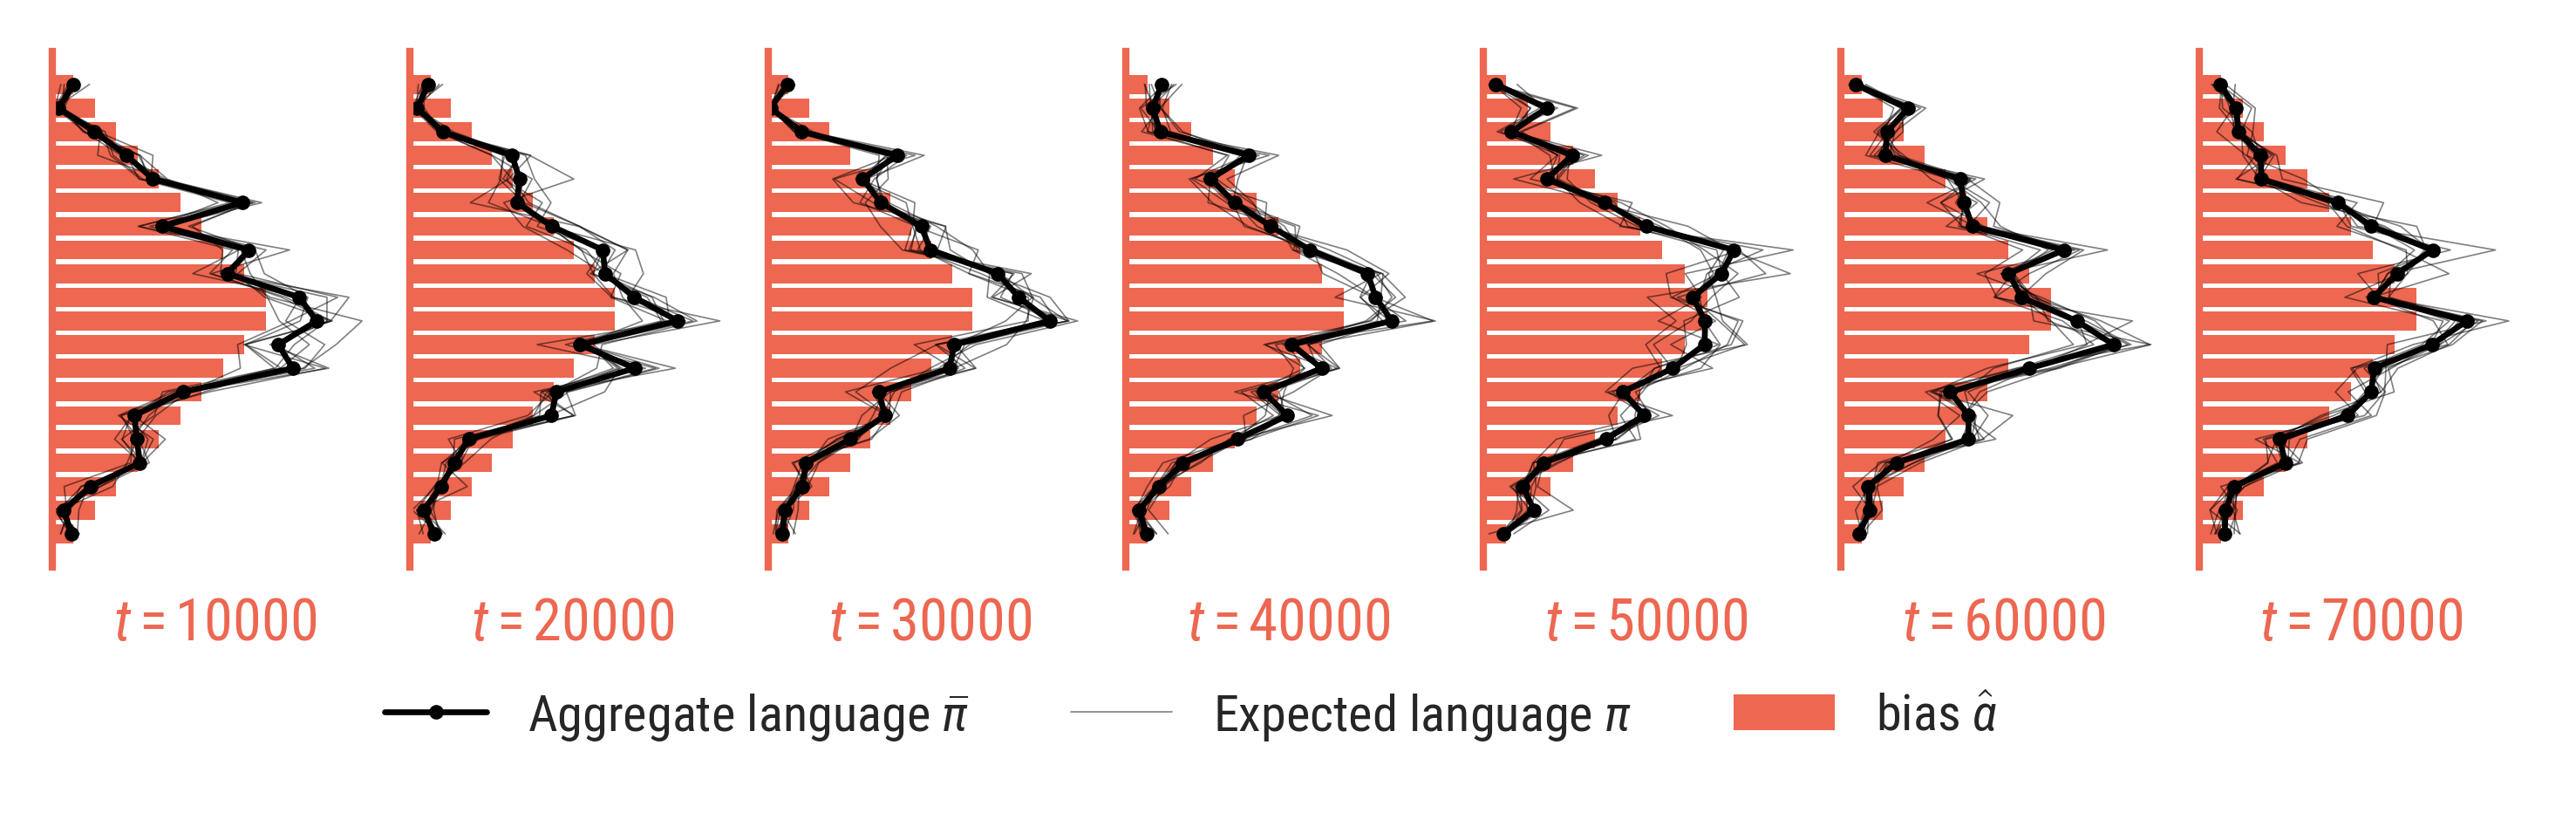

In [10]:
#Plot

figure(figsize=cm2inch(12,2.5))
G = gridspec.GridSpec(1, len(stops)-1)
cmap = CustomCmap('white', 'orange')
axes, imgaxes = [], []

alpha = array(setup['alpha'])
alpha_ps = alpha / alpha.sum()
K = setup['K']

for x, ps in enumerate(dists):   
    sharey = None if x == 0 else axes[-1]
    ax = subplot(G[0,x], sharey=sharey)
    axes.append(ax)

    # Plot!
    xs = arange(K)
    l = r'bias $\hat\alpha$' if x == 0 else ''
    pyplot.barh(xs, alpha_ps, color=get_color('orange'), label=l)
    
    l = r'Aggregate language $\bar{\pi}$' if x == 0 else ''
    plot(ps.mean(axis=0), xs, 'ko-', ms=2, lw=.8, label=l)
    
    plot(ps.T, xs, 'k', lw=.2, alpha=.5)
    sns.despine(ax=ax, bottom=True)

    xticks([]); yticks([]);
    time = stops[x+1]
    xlabel(f'$t = {time}$')

sca(axes[0])
l = r'Expected language $\pi$'
plot(0, 0, 'k', lw=.2, alpha=.5, label=l)
legend(bbox_to_anchor=(3.5,-.4), ncol=3, loc='lower center')
subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=.1, hspace=.1)
savefig('FIG11-BNG-language-change.pdf', bbox_inches='tight')
copyfig('FIG11-BNG-language-change.pdf')

# Old stuff

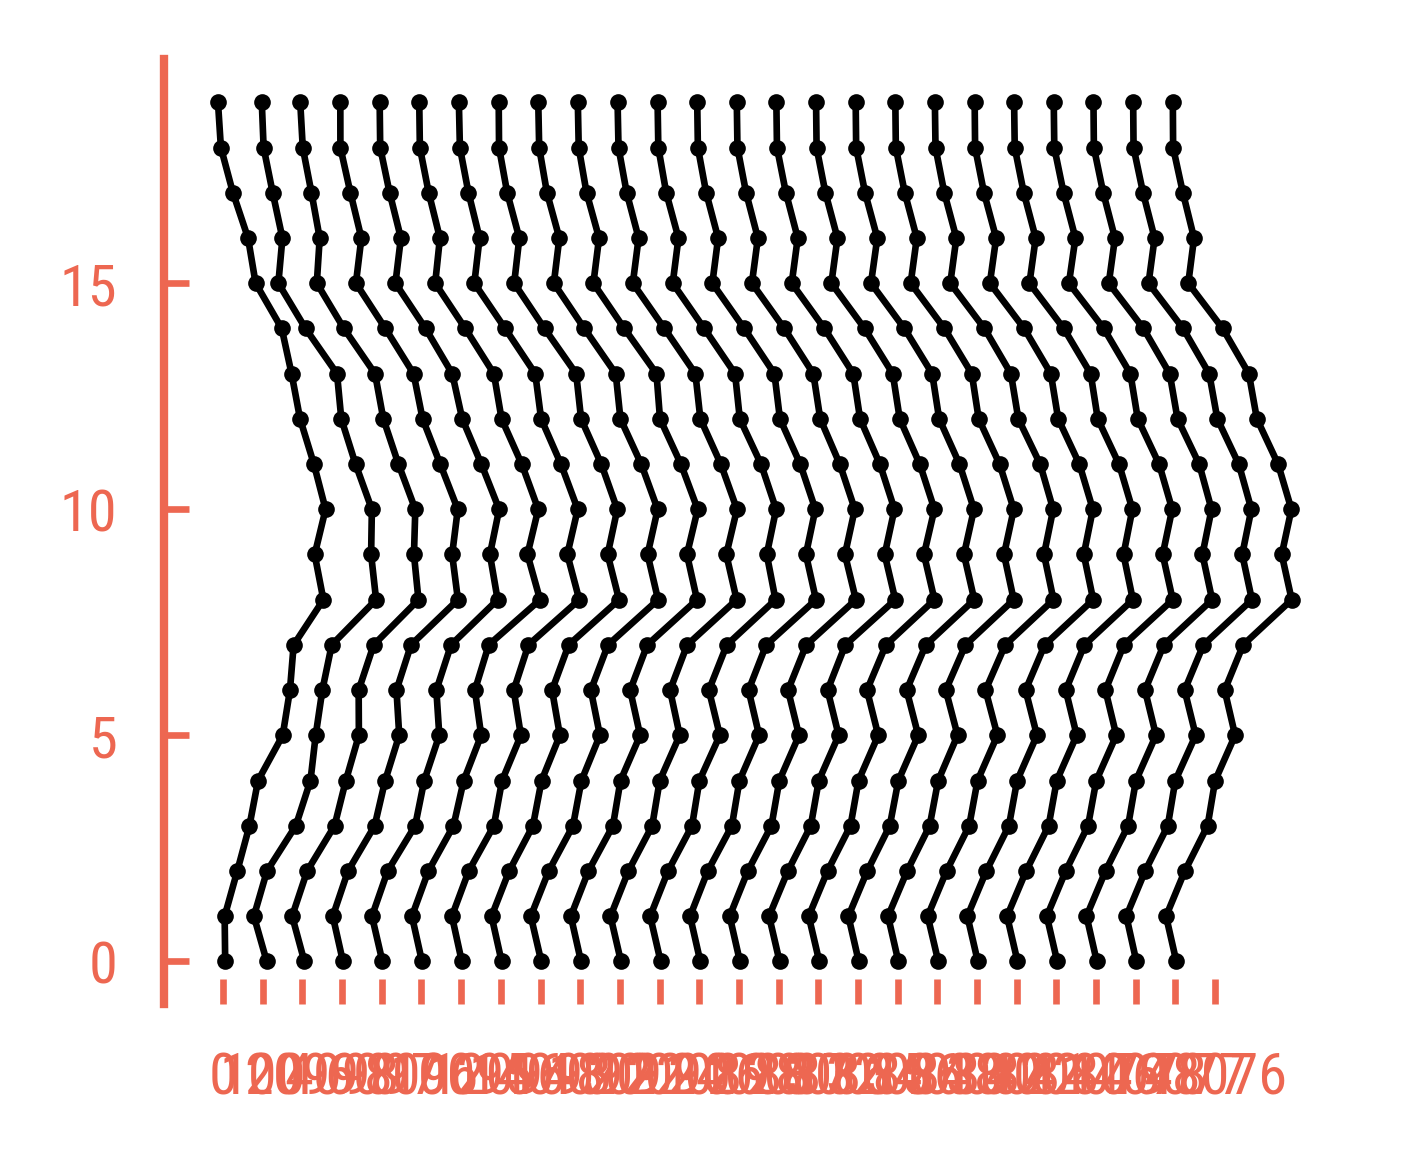

In [139]:
figure(figsize=cm2inch(5,4))
d = .03
xs = arange(K)

for x, ps in enumerate(dists):
    plot(ps.mean(axis=0) + d*x, xs, 'ko-', ms=2, lw=.8)
#     plot(ps.T + d*x, xs, 'k', lw=.2, alpha=.5)

sns.despine(bottom=True)
xticks(arange(0,len(stops))*d+d/2, stops);

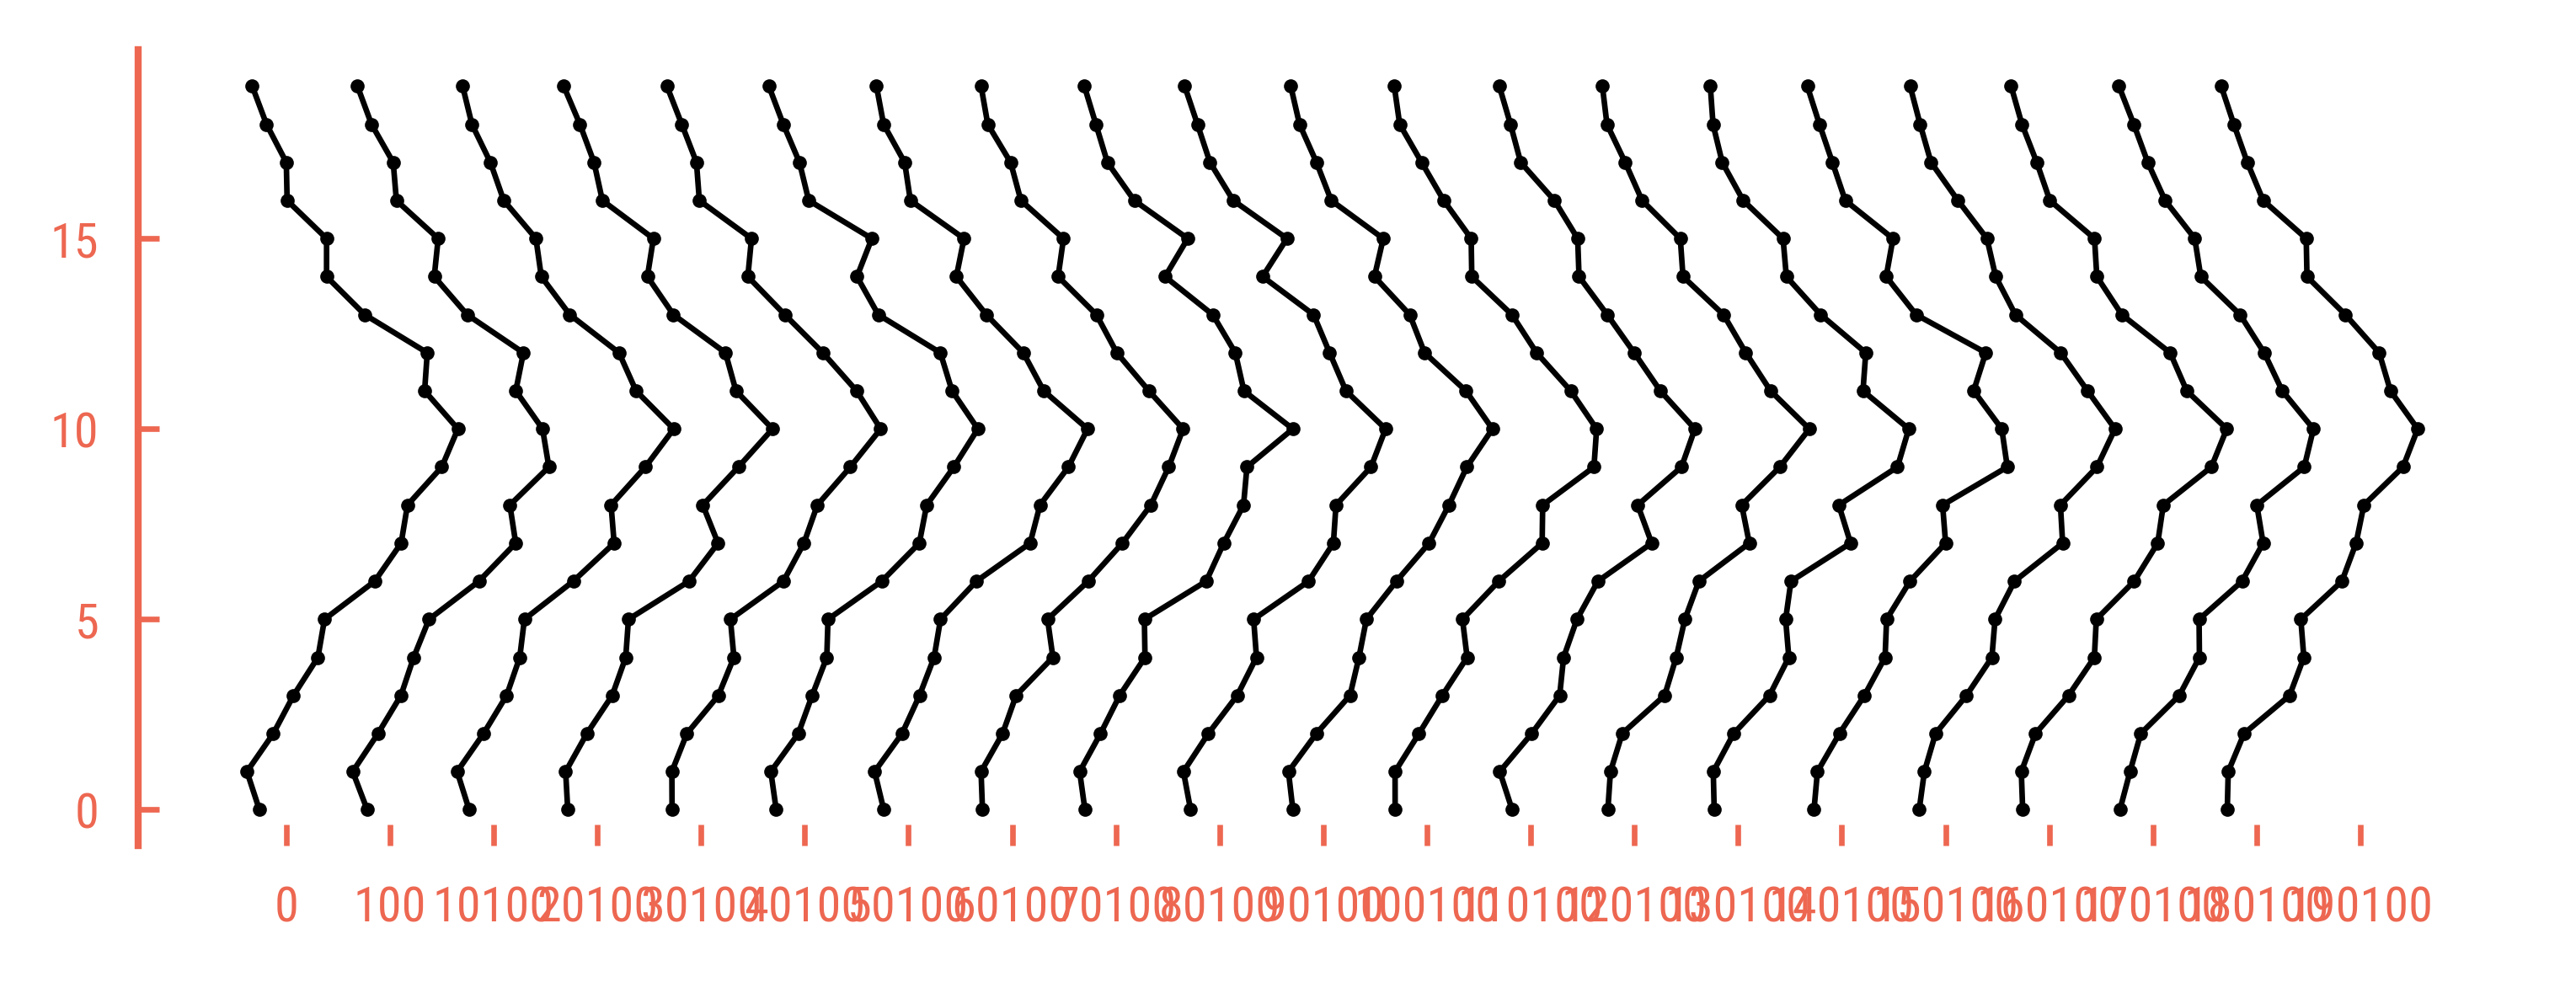

In [94]:

figure(figsize=cm2inch(12,4))

# Set up the 'stops' at which the intermediate state of
# the simulation is plotted
stops = unique(array([0] + array(stops).tolist()))
stops.sort()    
times = stops[1:] - stops[:-1]

# Prior
alpha = array(setup['alpha'])
alpha_ps = alpha / alpha.sum()
K = setup['K']

# Distance between plots
d = .05

# Show the agent distributions at certain times
prev_counts, utter = False, np.zeros((0,setup['K']))
for x, (remaining_time, time) in enumerate(zip(times, stops[1:])):

    # Continue simulation
    setup['T'] = remaining_time
    ps, counts, res = run(prev_counts, setup=setup)
    prev_counts = counts

    # Plot!
    xs = arange(K)
    plot(ps.mean(axis=0) + d*x, xs, 'ko-', ms=2, lw=.8)
#     plot(ps.T + d*x, xs, 'k', lw=.2, alpha=.5)

sns.despine(bottom=True)
xticks(arange(0,len(stops))*d+d/2, stops);